# Libraries

In [19]:
import numpy as np
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.interpolate import splprep, splev
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from pathlib import Path

%config InlineBackend.figure_formats=['retina']

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

from stabl.stabl import Stabl, plot_stabl_path
from stabl.preprocessing import remove_low_info_samples, LowInfoFilter
from stabl.visualization import boxplot_features

# Data

In [21]:
cell_pops = ['Bcells','CCR2nncMC', 'CCR2pcMC', 'CD41hiCD61hiPLT', 'CD4Tcm',
                        'CD4Tem', 'CD4Tnaive', 'CD4Trm', 'Tregnaive', 'Tregmem', 'Th1mem', 'Th1naive',
                        'CD8Trm', 'gdTcells', 'intMC', 'mDC', 'MDSC', 'NKT', 'pDC',
                        'CD62LpImmatureNeutrophils', 'CD8Tcm', 'CD8Tem', 'CD8Tnaive',
                        'CD61pCD41pPLT', 'CD62LnAgedNeutrophils', 'CD56brightCD16nNKcells', 'CD56dimCD16pNKcells']
times = ['Delta', 'P1', 'P2', 'P3']


In [22]:
dict_tot = {}
for time in times:
    dict_tot[time] = pd.DataFrame()
    dict_tot[time+'_unstim'] = pd.DataFrame()
    for cellpop in cell_pops:
        if time != 'Delta' or cellpop != 'NKT':
            X = pd.read_csv(Path('./Data', time, cellpop, 'X.csv'), index_col=0)
            X.columns = [cellpop + '_' + el for el in X.columns]
            dict_tot[time +'_unstim'] = pd.concat([dict_tot[time +'_unstim'] ,X], axis=1)
            X.index = [str(idx) + '_' + time for idx in X.index]
            dict_tot[time] = pd.concat([dict_tot[time] ,X], axis=1)
    y = pd.read_csv(Path('./Data', time, cellpop, 'y.csv'), index_col=0)
    #y.index = [str(idx) + '_' + time for idx in y.index]
    y.columns = ['label']
    dict_tot['y' + time] = y
        

In [23]:
df_tot = pd.concat([dict_tot[time] for time in times], axis='rows')

#df_tot = pd.concat([dict_tot[time] for time in ['P2']], axis='columns')

In [24]:
df_tot.shape

(80, 322)

# ANOVA

In [25]:
X_P1 = dict_tot['P1_unstim'].join(dict_tot['yP1'])
X_P1['TimePoint'] = 1
X_P2 = dict_tot['P2_unstim'].join(dict_tot['yP2'])
X_P2['TimePoint'] = 2
X_P3 = dict_tot['P3_unstim'].join(dict_tot['yP3'])
X_P3['TimePoint'] = 3
X_Delta = dict_tot['Delta_unstim'].join(dict_tot['yDelta'])
X_Delta['TimePoint'] = 4

In [26]:
df_anova = pd.concat([X_P2],axis='rows').dropna(subset=['label']).reset_index(drop=True)
df_anova.fillna(df_anova.median(), inplace=True)


In [27]:
df_anova['label'] = df_anova.label.astype(int)

In [28]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
pvalues_anova = pd.DataFrame(index = df_anova.columns)
for feature in df_anova.columns:
    # Ordinary Least Squares (OLS) model
    model = ols(f'{feature} ~ C(label)*C(TimePoint)', data=df_anova).fit()
    table = sm.stats.anova_lm(model,typ=1)
    pvalues_anova.loc[feature,'pvalue_anova']=table.loc['C(label)', 'PR(>F)']

> model = ols(f'{feature} ~ C(label)*C(TimePoint)', data=df_anova).fit() 

This line of code is using the OLS (ordinary least squares) function from the statsmodels library in Python to perform a two-way ANOVA (analysis of variance) with interaction.

The dependent variable (or label) is being regressed on two categorical independent variables: TimePoint and label. The independent variables are being specified as factors using the C() function.

The * symbol is used to indicate an interaction effect between TimePoint and label. This means that the effect of TimePoint on the dependent variable depends on the level of label, and vice versa.

The 'feature' variable is the name of the dependent variable being analyzed, and 'df_anova' is the name of the data frame containing the data to be analyzed. The fit() method is called on the OLS model object to fit the model to the data and obtain the regression coefficients.

> model.params

Intercept                            0.103080

C(label)[T.1]                      0.066406

C(TimePoint)[T.2]                    0.075700

C(TimePoint)[T.3]                    0.014623

C(TimePoint)[T.4]                   -0.027380

C(label)[T.1]:C(TimePoint)[T.2]   -0.086079

C(label)[T.1]:C(TimePoint)[T.3]   -0.052524

C(label)[T.1]:C(TimePoint)[T.4]   -0.152485

dtype: float64


y = 0.103080 + 0.066406C(label) + 0.075700C(TimePoint_2) + 0.014623C(TimePoint_3) - 0.027380C(TimePoint_4) - 0.086079*C(label)C(TimePoint_2) - 0.052524C(label)C(TimePoint_3) - 0.152485C(label)*C(TimePoint_4)

In this formula, you would substitute the actual values of label and TimePoint for each observation in your dataset to obtain the predicted value of the dependent variable for that observation.

> table = sm.stats.anova_lm(model,typ=1)

Create Anova Table : https://www.itl.nist.gov/div898/handbook/prc/section4/prc433.htm#:~:text=The%20ANOVA%20table%20also%20shows,hypotheses%20about%20the%20population%20means.&text=When%20the%20null%20hypothesis%20of,be%20of%20approximately%20equal%20magnitude.

> pvalues_anova.loc[feature,'pvalue_anova']=table.loc['C(label)', 'PR(>F)']

Simply gets the p-value associated with the feature selected.

In [29]:
pvalues_anova = pvalues_anova.fillna(1)

# t-SNE

In [30]:
df_corr = df_tot.corr()

In [31]:
tsne = TSNE(learning_rate='auto', random_state=4).fit(df_tot.fillna(df_tot.median()).T)
df_tsne = pd.DataFrame(data=tsne.embedding_, index = df_tot.columns, columns = ['coor1', 'coor2'])

In [32]:
clusterer = KMeans(n_clusters=10, n_init=100, random_state=42, init='k-means++')
cluster_labels = clusterer.fit_predict(df_tsne[['coor1', 'coor2']])
cen_x, cen_y = clusterer.cluster_centers_.T
df_tsne['cluster'] = cluster_labels

In [33]:
df_tsne = pd.concat([df_tsne, pvalues_anova], axis='columns')

# Correlation Plot

In [34]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = [(1, 0, 0), (.7, .4, 0), (0, 0, 1)]  # R -> G -> B
colors = [(0,(0, 0, 1)),(.35,(227/256, 163/256, 103/256)),(.65,(227/256, 163/256, 103/256)), (1,(1, 0, 0))]
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'custom_cmp'

cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256,gamma=1)

/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_81370/1912660278.py:48: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  scatter = plt.scatter(df_tsne.coor1[:100],
/var/folders/v_/wlr8vlpn1tzgb7_j_7kncp4w0000gn/T/ipykernel_81370/1912660278.py:75: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  scatter = plt.scatter(df_tsne.coor1,


6

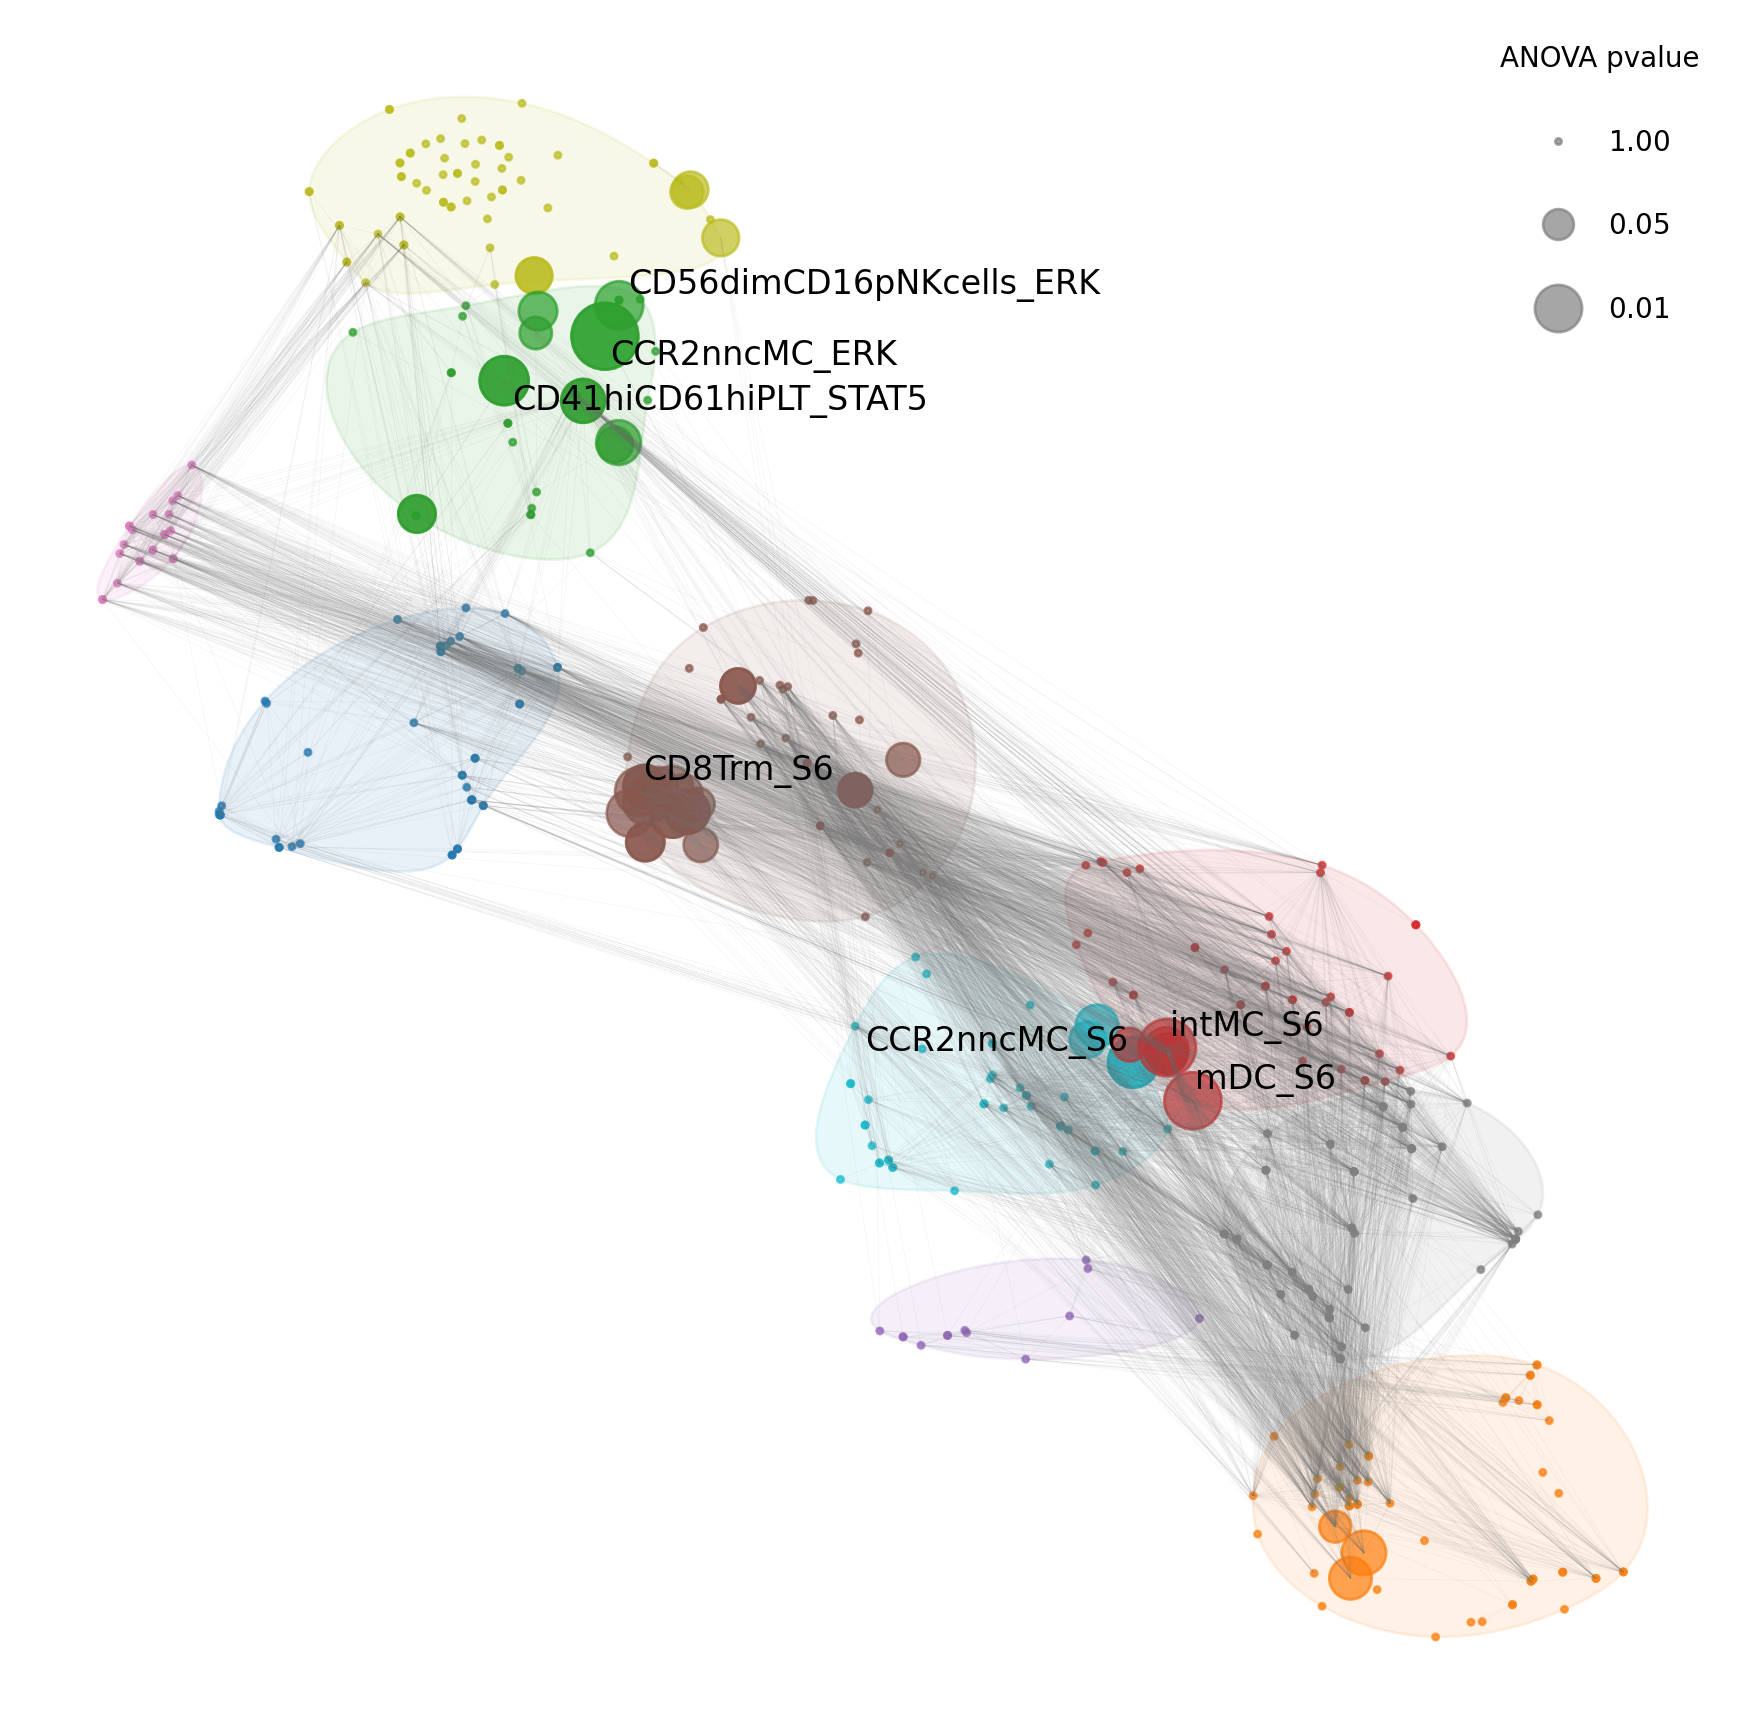

In [35]:
from adjustText import adjust_text
from matplotlib import colors

CORR_THRESH = .7
TIMESTAMP = 'P1'
#sizes_source = 'pvalue_'+TIMESTAMP
sizes_source = 'pvalue_anova'
#colors_source = 'effect_dir_'+TIMESTAMP

SIZES = []
for value in df_tsne[sizes_source].astype(float):
    if value > 0.05:
        SIZES.append(5.)
    else:
        SIZES.append(2*(-np.log10(value)*6)**2)

SIZES = np.array(SIZES)

def transform_to_color(i):
    if i < np.inf:
        return 'C' + str(int(i))
    else:
        return 'white'

COLORS = [transform_to_color(i) for i in df_tsne.cluster]

# --DRAWING CLUSTERS--
fig, ax = plt.subplots(figsize=(11, 11))

for i in np.unique(cluster_labels):
    points = df_tsne[df_tsne.cluster == i][['coor1', 'coor2']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    
    tck, _ = splprep([x_hull, y_hull], s=0, per = True)
    xx, yy = splev(np.linspace(0, 1, 100), tck, der = 0)
    
    # plot shape
    plt.fill(xx, yy, alpha=.1, color='C'+str(i)) #, label=f'Cluster {i}'
    
# --DRAWING POINTS A FEW POINTS TO CREATE THE LEGENDS FOR PVALUES--
scatter = plt.scatter(df_tsne.coor1[:100],
                     df_tsne.coor2[:100], 
                     s=SIZES[:100], 
                     marker='o', 
                     c=COLORS[:100],
                     norm=colors.CenteredNorm(),
                     edgecolors=None,
                     cmap=cmap,
                     alpha=.7
                    )

def funct(s):
    to_ret=np.zeros(len(s))
    for idx, el in enumerate(s):
        if el==5:
            to_ret[idx] = 1
        else:
            to_ret[idx] = np.exp(np.log(10)*(-((el/2)**(1/2))/6))
    return to_ret

# kw = dict(prop="sizes", num=[0, .1, .2], color='gray', fmt="{x:.2f}",
#            func=lambda s: np.sqrt(s)/75 - 0.01)£

kw = dict(prop="sizes", num=[1, 0.05, 0.01, 0.001], color='gray', func=funct)
legend = ax.legend(*scatter.legend_elements(**kw), loc="upper right", title="ANOVA pvalue",labelspacing=2, frameon=False)

# --DRAWING ALL THE POINTS--
scatter = plt.scatter(df_tsne.coor1,
                     df_tsne.coor2, 
                     s=SIZES, 
                     marker='o', 
                     c=COLORS,
                     norm=colors.CenteredNorm(),
                     edgecolors=None,
                     cmap=cmap,
                     alpha=.7
                    )

ax.axis("off")

# fig.colorbar(scatter,
#              anchor=(0,0),
#              ax=ax, 
#              shrink=.2, 
#              label='Effect direction', 
#              aspect=10, 
#              use_gridspec=True,
#              location='left')

for i in df_tot.columns:
    for j in df_tot.columns:
        if df_corr.loc[i,j]>=CORR_THRESH and df_corr.loc[i,j] < 1:
            sub_df = df_tsne.loc[[i, j]]
            ax.plot(sub_df.coor1, sub_df.coor2, linewidth=.2,color='gray', alpha=.05)


annot=[]        
for i, txt in enumerate(df_tsne.index):
    if df_tsne.iloc[i][sizes_source] <= 0.01:
        annot.append(ax.annotate(txt, (df_tsne.iloc[i].coor1, df_tsne.iloc[i].coor2), fontsize=12))
        
adjust_text(annot)